In [1]:
import morphs
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

In [5]:
from joblib import Parallel, delayed

In [6]:
def permute_units(rep, num_samples=50):
    '''
    destroys simultaneous information
    permutes in-place (still returns value so you can permute_units(rep.copy()))
    '''
    assert rep.shape[1] % num_samples == 0
    num_units = int(rep.shape[1] / num_samples)
    #permute each unit separately
    for unit in range(num_units):
        rep[:, num_samples*unit:num_samples*(unit+1)] = np.random.permutation(rep[:, num_samples*unit:num_samples*(unit+1)])
    return rep

In [7]:
def test_permute_units():
    num_samples = 5
    num_units = 10
    repititions = 15
    rep = np.arange(num_samples * num_units * repititions).reshape(repititions, num_samples * num_units)
    shuffled_rep = permute_units(rep.copy(), num_samples=num_samples)
    assert np.all(np.sort(shuffled_rep.reshape(-1)) == np.arange(num_samples * num_units * repititions)), 'missing elements'
    assert np.all(np.sort(shuffled_rep, axis=0) == rep), 'wrong shape'
    for unit in range(num_units):
        assert np.all(np.sort(shuffled_rep[:, num_samples*unit:num_samples*(unit+1)], axis=0) == rep[:, num_samples*unit:num_samples*(unit+1)]), 'shuffled between units'
        ind = np.argsort(shuffled_rep[:,num_samples*unit])
        assert np.all(shuffled_rep[ind, num_samples*unit:num_samples*(unit+1)] == rep[:, num_samples*unit:num_samples*(unit+1)]), 'units time shuffled'
test_permute_units()

In [8]:
def fit_shuffled_AUC_df(X, labels, morph_dims, num_shuffles):
    samples = []
    for morph_dim in morph_dims:
        l, g = morph_dim
        l_rep = X[labels==l, :]
        g_rep = X[labels==g, :]
        y = np.concatenate([np.zeros(l_rep.shape[0]), np.ones(g_rep.shape[0])])

        idxs = np.arange(num_shuffles + 1)
        shuffled = idxs != 0
        aucs = np.zeros_like(idxs, dtype=float)

        for i in idxs:
            if shuffled[i]:
                l_rep = permute_units(l_rep)
                g_rep = permute_units(g_rep)
            train_x, test_x, train_y, test_y = train_test_split(np.concatenate([l_rep, g_rep]),
                                                                y, test_size=0.5, random_state=42)
            model = LogisticRegression(penalty='l2').fit(train_x, train_y)
            predicted_values = model.predict_proba(test_x)[:, 1]
            aucs[i] = roc_auc_score(test_y, predicted_values)
        samples.append(pd.DataFrame(data={'AUC':aucs, 'morph_dim':morph_dim, 'shuffled':shuffled, 'idx':idxs}))
    return pd.concat(samples, ignore_index=True)

In [9]:
def gen_fit_shuffled_AUC_df(block_path, num_shuffles):
    subj = morphs.data.parse.bird_id(block_path)
    accuracies, cluster_accuracies = morphs.load.cluster_accuracies()
    good_clusters = morphs.data.accuracies.good_clusters(cluster_accuracies[block_path])
    
    spikes = morphs.load.ephys_data(block_path, good_clusters=good_clusters, collapse_endpoints=True)
    morph_dims = np.sort(spikes['morph_dim'].unique())[1:]
    morphs.data.parse.stim_id(spikes)
    X, labels = morphs.spikes.create_neural_rep(spikes[spikes['end']], max_id_len=1)
    
    samples_df = fit_shuffled_AUC_df(X, labels, morph_dims, num_shuffles)
    samples_df['block_path'] = block_path
    samples_df['subj'] = subj
    samples_df['num_units'] = len(good_clusters)
    return samples_df

In [10]:
def gen_all_fit_shuffled_AUC_df(num_shuffles, parallel=True, n_jobs=morphs.parallel.N_JOBS):
    accuracies, cluster_accuracies = morphs.load.cluster_accuracies()
    good_recs = morphs.data.accuracies.good_recs(cluster_accuracies)
    if parallel:
        all_samples = Parallel(n_jobs=n_jobs)(delayed(gen_fit_shuffled_AUC_df)(block_path, num_shuffles) for block_path in good_recs)
    else:
        all_samples = [gen_fit_shuffled_AUC_df(block_path, num_shuffles)
                       for block_path in good_recs]
    return pd.concat(all_samples, ignore_index=True)

In [11]:
accuracies, cluster_accuracies = morphs.load.cluster_accuracies()
good_recs = morphs.data.accuracies.good_recs(cluster_accuracies)

In [12]:
block_path = np.random.choice(morphs.data.accuracies.good_recs(cluster_accuracies))
subj = morphs.data.parse.bird_id(block_path)
good_clusters = morphs.data.accuracies.good_clusters(cluster_accuracies[block_path])

In [13]:
num_shuffles = 4
samples_df = gen_fit_shuffled_AUC_df(block_path, num_shuffles)

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


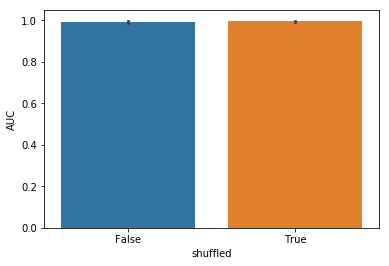

In [14]:
ax = sns.barplot(x='shuffled', y='AUC', data=samples_df)

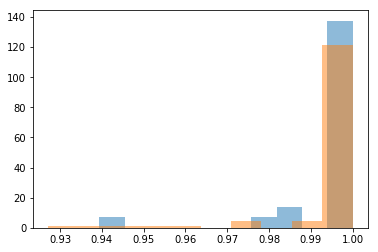

In [15]:
for shuffled, shuffled_group in samples_df.groupby('shuffled'):
    plt.hist(shuffled_group['AUC'].values, alpha=.5, density=True)

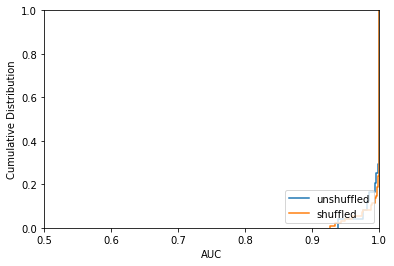

In [16]:
fig = plt.figure()
ax = plt.gca()
for shuffled, shuffled_group in samples_df.groupby('shuffled'):
    morphs.plot.cumulative_distribution(shuffled_group['AUC'].values, scaled=True, label='shuffled' if shuffled else 'unshuffled')
ax.set_ylim(0, 1)
ax.set_xlim(.5, 1)
ax.set_ylabel('Cumulative Distribution')
ax.set_xlabel('AUC')
ax.legend(loc='lower right');

In [17]:
all_samples_df = gen_all_fit_shuffled_AUC_df(num_shuffles)

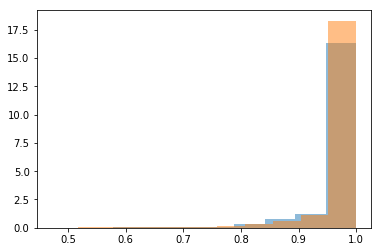

In [18]:
for shuffled, shuffled_group in all_samples_df.groupby('shuffled'):
    plt.hist(shuffled_group['AUC'].values, alpha=.5, density=True)

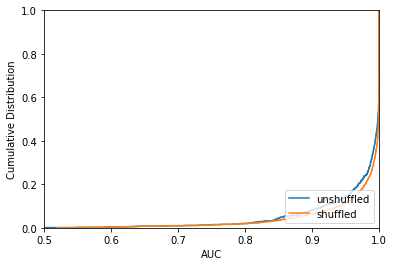

In [19]:
fig = plt.figure()
ax = plt.gca()
for shuffled, shuffled_group in all_samples_df.groupby('shuffled'):
    morphs.plot.cumulative_distribution(shuffled_group['AUC'].values, scaled=True, label='shuffled' if shuffled else 'unshuffled')
ax.set_ylim(0, 1)
ax.set_xlim(.5, 1)
ax.set_ylabel('Cumulative Distribution')
ax.set_xlabel('AUC')
ax.legend(loc='lower right');

In [20]:
all_samples_df.loc[all_samples_df['subj'] == 'st1107', 'subj'] = 'B1107'

In [21]:
all_samples_df['behave_subj'] = [subj in morphs.subj.BEHAVE_SUBJS for subj in all_samples_df['subj']]

In [22]:
psychometric_params = morphs.load.psychometric_params()
psychometric_params

{'B1082': {'ae': array([3.45413076e-02, 9.61020140e-01, 1.26630095e-01, 4.88125767e+01]),
  'af': array([ 0.05601262,  0.94862689,  0.13856467, 51.60830661]),
  'ag': array([ 0.04943956,  0.94570797,  0.1699687 , 40.41101718]),
  'ah': array([6.51486070e-02, 9.59232529e-01, 1.48832788e-01, 6.88214363e+01]),
  'be': array([4.74273792e-02, 9.66950751e-01, 1.86421284e-01, 6.31172051e+01]),
  'bf': array([4.63522879e-02, 9.54589960e-01, 2.44995491e-01, 6.88413935e+01]),
  'bg': array([4.68393213e-02, 9.50146781e-01, 2.91401812e-01, 5.31775090e+01]),
  'bh': array([5.15553773e-02, 9.36509462e-01, 2.06887983e-01, 7.52997723e+01]),
  'ce': array([6.50063659e-02, 9.65465617e-01, 1.91000517e-01, 6.62982912e+01]),
  'cf': array([ 0.05954785,  0.94954191,  0.20562972, 45.00137051]),
  'cg': array([ 0.06412609,  0.94917161,  0.21870895, 55.13779286]),
  'ch': array([ 0.07084469,  0.95578936,  0.31225774, 39.7764666 ]),
  'de': array([ 0.05648395,  0.96223462,  0.27168341, 50.34762748]),
  'df': ar

In [23]:
all_samples_df['behave_dim'] = False
for subj, subj_group in all_samples_df.groupby('subj'):
    if subj in morphs.subj.BEHAVE_SUBJS:
        for morph_dim, dim_group in subj_group.groupby('morph_dim'):
            if morph_dim in psychometric_params[subj]:
                all_samples_df.loc[dim_group.index, 'behave_dim'] = True

In [24]:
all_samples_df['legend'] = 'error'
all_samples_df.loc[~all_samples_df['behave_subj'], 'legend'] = 'Naive'
all_samples_df.loc[all_samples_df['behave_subj'] & all_samples_df['behave_dim'], 'legend'] = 'Relevant Dimensions'
all_samples_df.loc[all_samples_df['behave_subj'] & ~all_samples_df['behave_dim'], 'legend'] = 'Irrelevant Dimensions'

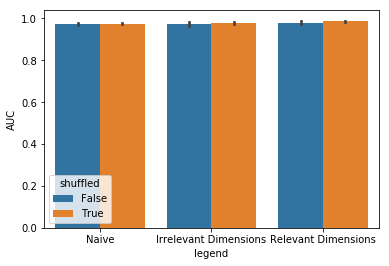

In [25]:
ax = sns.barplot(x='legend', y='AUC', hue='shuffled', data=all_samples_df)

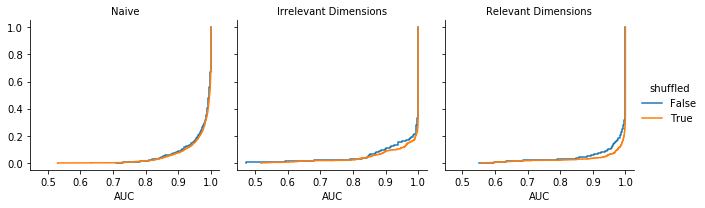

In [26]:
g = sns.FacetGrid(all_samples_df, col='legend', hue='shuffled')
g = g.map(morphs.plot.cumulative_distribution, 'AUC', scaled=True, label='shuffled' if shuffled else 'unshuffled')
g = g.set_titles('{col_name}')
g = g.add_legend()

In [27]:
import scipy as sp

In [28]:
for legend, legend_group in all_samples_df.groupby('legend'):
    print(legend)
    lggb = legend_group.groupby('shuffled')
    print(sp.stats.mstats.ks_twosamp(lggb.get_group(True)['AUC'], lggb.get_group(False)['AUC']))

Irrelevant Dimensions
(0.11019736842105232, 0.10432082453930556)
Naive
(0.07343750000000063, 0.03178592065807014)
Relevant Dimensions
(0.1085526315789485, 0.006483908409130259)


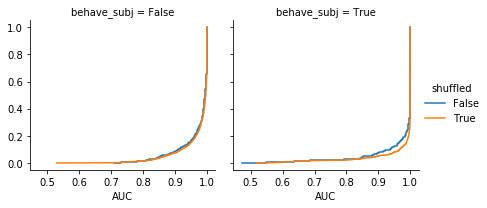

In [29]:
g = sns.FacetGrid(all_samples_df, col='behave_subj', hue='shuffled')
g = g.map(morphs.plot.cumulative_distribution, 'AUC', scaled=True, label='shuffled' if shuffled else 'unshuffled')
# g = g.set_titles('{col_name}')
g = g.add_legend()

In [30]:
for behave, behave_group in all_samples_df.groupby('behave_subj'):
    print(behave)
    bggb = behave_group.groupby('shuffled')
    print(sp.stats.mstats.ks_twosamp(bggb.get_group(True)['AUC'], bggb.get_group(False)['AUC']))

False
(0.07343750000000063, 0.03178592065807014)
True
(0.10910087719298156, 0.0003383997584589806)
